<a href="https://colab.research.google.com/github/arkadijshmelev/RFM_Client_Clustering/blob/master/RFM_Client_Clustering_Project_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Постановка задачи




Построить модель кластеризации клиентов на основе их покупательской способности, частоты заказов и срока давности последней покупки, определить профиль каждого из кластеров.



# 2. Библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

from sklearn import mixture
from sklearn import manifold
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn import ensemble
import warnings 

from IPython.display import display, HTML

warnings.filterwarnings("ignore")

plt.rcParams["patch.force_edgecolor"] = True

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 3. Данные


In [3]:
# Загрузим данные с google drive.
data = drive.CreateFile({'id': '1wa3GJ3yvf-j5Sg1oZZwC2LSmfSc1FKW9'})
data.GetContentFile('customer_segmentation_project.csv')

In [4]:
data = pd.read_csv(
    'customer_segmentation_project.csv', 
    encoding='ISO-8859-1', 
    dtype={'CustomerID': str,'InvoiceID': str}
)
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


# 4. Признаки

* InvoiceNo — номер счёта-фактуры (уникальный номинальный шестизначный номер, присваиваемый каждой транзакции; буква "C" в начале кода указывает на отмену транзакции);
* Stock Code — код товара (уникальное пятизначное целое число, присваиваемое каждому отдельному товару);
* Description — название товара;
* Quantity — количество каждого товара за транзакцию; 
* InvoiceDate — дата и время выставления счёта/проведения транзакции;
* UnitPrice — цена за единицу товара в фунтах стерлингов;
* CustomerID — идентификатор клиента (уникальный пятизначный номер, однозначно присваиваемый каждому клиенту);
* Country — название страны, в которой проживает клиент.




In [5]:
# Выведем информацию.
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  object 
 7   Country      541909 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 33.1+ MB
None


In [6]:
# Переведем признак InvoiceDate в формат datetime.
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [7]:
print(f'Данные представлены в промежутке от {data.InvoiceDate.min()} до {data.InvoiceDate.max()}')

Данные представлены в промежутке от 2010-12-01 08:26:00 до 2011-12-09 12:50:00


In [8]:
print('Максимальное количество товаров на складе:')
print(data['Quantity'].max(), '\n')
print('Минимальное количество товаров на складе:')
print(data['Quantity'].min(), '\n')
print('Стоимость самого дешевого товара:')
print(round(data[data['UnitPrice'] >= 0]['UnitPrice'].min()))

Максимальное количество товаров на складе:
80995 

Минимальное количество товаров на складе:
-80995 

Стоимость самого дешевого товара:
0


In [9]:
print('Количество уникальных клиентов, которые покупали товары:')
print(data['CustomerID'].nunique(), '\n')
print('Количество уникальных стран:')
print(data[data['Country'] != 'Unspecified']['Country'].nunique(), '\n')
print('Идентификатор самого популярного товара:')
print(data['StockCode'].mode()[0])

Количество уникальных клиентов, которые покупали товары:
4372 

Количество уникальных стран:
37 

Идентификатор самого популярного товара:
85123A


# 5. Предобработка и очистка данных

In [10]:
# Отобразим пропуски.
print(data.isnull().sum(), '\n')
print('Общее количество пропусков:', data.isnull().sum().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64 

Общее количество пропусков: 136534


Пропуски в столбце с идентификатором клиента и описанием товара свидетельствуют о некорректных/незавершённых транзакциях.

In [11]:
# Удалим пропуски.
data = data.dropna()
# Отобразим пропуски.
print(data.isnull().sum(), '\n')
print('Общее количество пропусков:', data.isnull().sum().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64 

Общее количество пропусков: 0


In [12]:
print('Общее количество дублирующихся записей:', data.duplicated().sum())

Общее количество дублирующихся записей: 5225


In [13]:
# Удалим дубликаты из таблицы.
data = data.drop_duplicates()
print('Общее количество дублирующихся записей:', data.duplicated().sum())

Общее количество дублирующихся записей: 0


Было замечено, что в столбце с количеством товара есть отрицательные значения. Разберемся, откуда они взялись. Выведем первые 5 строк таблицы, в которой столбец Quantity меньше 0.

In [14]:
negative_quantity = data[(data['Quantity'] < 0)]
print('Количество записей с отрицательным числом: {}'.format(negative_quantity.shape[0]), '\n')
display(negative_quantity.head())

Количество записей с отрицательным числом: 8872 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom


Таких записей почти девять тысяч. Не похоже на какую-то ошибку или выбросы, ведь случаев слишком много.

При просмотре таблицы можно заметить следующее:

- Номер заказа (InvoiceNo) и код товара (StockCode) могут содержать не только числа, но и символы.

- Как было сказано в описании датасета, символ "C" перед номером заказа указывает на возврат. То есть, по идее, в таблице должна также находиться запись с точно такими же идентификаторами клиента и товара, но c номером заказа без символа "C" и c положительным количеством товара.

- Код товара может содержать различные специальные символы: например, символ "D", судя по описанию товара (столбец Description), означает наличие скидки.

- Как на каждый уникальный товар, так и на его возврат заводится отдельная транзакция (запись в таблице).

Разберёмся с возвратами. Сейчас на каждый уникальный товар заведена отдельная строка в таблице — это мешает определить общее количество возвратов.

Чтобы подсчитать число возвратов, сначала необходимо определить, сколько уникальных товаров указано в транзакции (корзине/basket) для каждой уникальной пары «клиент-заказ»:

In [15]:
temp = data.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket.head()

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


Добавим во вспомогательную таблицу nb_products_per_basket признак отмены заказа (order_canceled): он равен 1, если транзакция является возвратом, и 0 — в противном случае.

In [16]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x: 1 if x[0] == 'C' else 0)
print('Процент заказов в таблице, являющимися возвратами:')
print(round(nb_products_per_basket['order_canceled'].value_counts(normalize=True)[1]*100))

Процент заказов в таблице, являющимися возвратами:
16


Давайте поближе взглянем на отмененные заказы:


In [17]:
nb_products_per_basket[nb_products_per_basket['order_canceled'] == 1].head()

,CustomerID,InvoiceNo,Number of products,order_canceled
1,12346,C541433,1,1
23,12352,C545329,2,1
24,12352,C545330,1,1
25,12352,C547388,7,1
39,12359,C549955,2,1


Найдем в таблице со всеми транзакциями записи принадлежащие клиенту с идентификатором 12346:


In [18]:
data[data['CustomerID'] == '12346']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom


Итак, вот пример пары «заказ-отмена». Обратим внимание на столбцы StockCode, UnitPrice, CustomerID и Quantity, сравним их для двух транзакций. 

Выдвигаем гипотезу: для каждой отменённой транзакцию в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара.

In [19]:
for i in negative_quantity.index:
    customer_id, stock_code, quantity = data.loc[
        i, ['CustomerID', 'StockCode', 'Quantity']
    ]
    if (
        len(
            data[
                (data['CustomerID'] == customer_id)
                & (data['StockCode'] == stock_code)
                & (data['Quantity'] == abs(quantity))
            ]
        )
        == 0
    ):
        print('Гипотеза не верна.')
        print(f'Контрпример: транзакция {i} для клиента {customer_id}')
        break

Гипотеза не верна.
Контрпример: транзакция 141 для клиента 14527


Приведем контр-пример, на котором "споткнулась" наша прошлая гипотеза. Посмотрим на клиента с идентификатором 14527:

In [20]:
data[data['CustomerID'] == '14527'].head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
8963,537159,22112,CHOCOLATE HOT WATER BOTTLE,6,2010-12-05 13:17:00,4.95,14527,United Kingdom
8964,537159,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-05 13:17:00,4.95,14527,United Kingdom
8965,537159,21479,WHITE SKULL HOT WATER BOTTLE,1,2010-12-05 13:17:00,3.75,14527,United Kingdom
8966,537159,22114,HOT WATER BOTTLE TEA AND SYMPATHY,6,2010-12-05 13:17:00,3.95,14527,United Kingdom


Обратим внимание на первую строку, в которой располагается заказ C536379 с признаком отмены — противоположных ему аналогов по количеству товаров мы не найдем. Причина кроется в типе товара: данный товар обозначен как товар со скидкой (StockCode), и, по-видимому, для таких транзакций нет аналогов с положительным числом товаров в заказе. Учтём это наблюдение на будущее.

Выдвигаем новую гипотезу: для каждой отменённой транзакции в базе данных (таблица data) существует её аналог с тем же кодом товара, идентификатором клиента и противоположным значением количества товара, если на товар не распространяются скидки.

In [21]:
data_check = negative_quantity[negative_quantity['StockCode'] != 'D']

for index, col in data_check.iterrows():
  if data[(data['CustomerID'] == col['CustomerID']) & (data['Quantity'] == -col['Quantity'])
    & (data['Description'] == col['Description'])].shape[0] == 0:
    print(col)
    print('Вторая гипотеза тоже является не верной.')
    break

InvoiceNo                              C536383
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
Quantity                                    -1
InvoiceDate                2010-12-01 09:49:00
UnitPrice                                 4.65
CustomerID                               15311
Country                         United Kingdom
Name: 154, dtype: object
Вторая гипотеза тоже является не верной.


Посмотрим, где кроется проблема. В качестве контр-примера приведем транзакции, относящиеся к клиенту с идентификатором 15311 и товаром под кодом 35004C:


In [22]:
data[(data['CustomerID'] == '15311') & (data['StockCode'] == '35004C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
9200,537195,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-05 13:55:00,4.65,15311,United Kingdom
18196,C537805,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-08 13:18:00,4.65,15311,United Kingdom
28630,538651,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2010-12-13 15:07:00,4.65,15311,United Kingdom
39381,C539640,35004C,SET OF 3 COLOURED FLYING DUCKS,-3,2010-12-20 15:27:00,4.65,15311,United Kingdom
44157,540157,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-05 11:41:00,4.65,15311,United Kingdom
59542,541293,35004C,SET OF 3 COLOURED FLYING DUCKS,12,2011-01-17 13:39:00,4.65,15311,United Kingdom
78333,C542866,35004C,SET OF 3 COLOURED FLYING DUCKS,-2,2011-02-01 12:14:00,4.65,15311,United Kingdom


* На первой строке мы видим заказ с отменой (номер заказа начинается с символа C). Однако возникает вопрос: на какой заказ пришла эта отмена, ведь более ранних записей о транзакциях, связанных с этим клиентом, нет.
Ответ состоит в том, что заказ на покупку данного товара от клиента поступил раньше декабря 2010 года, а этих данных в нашей таблице нет. Это очень популярная проблема, которая возникает практически при любой работе с транзакциями: есть только фрагмент из общих данных, однако неизвестно, что предшествовало этому фрагменту.

* По двум следующим строкам видно, что клиент может отменить не весь заказ, а только его часть (5 декабря клиент покупает 12 единиц товара, а 8 декабря оформляет возврат только на одну единицу товара). Мы должны принять это во внимание на будущее

Итак, теперь мы знаем все особенности отмены заказов. При сегментировании клиентов мы будем определять их покупательскую способность, а для этого очень важно учитывать возвраты товаров. Поэтому давайте создадим в данных о транзакциях признак QuantityCanceled, который будет указывать на количество возвращённого впоследствии товара для каждой транзакции. 

Сразу обговорим, что мы не будем учитывать сложные пограничные случаи:
1. Отменённая транзакция не имеет противоположной (на транзакцию-возврат не нашлось ни одной транзакции на покупку).
2. Количество возвращённого товара в транзакции-возврате больше, чем количество товара, которое указано в любой из отдельных транзакций на покупку (это случай, когда клиент сделал несколько заказов одного и того же товара, а потом оформил возврат на все товары разом).


Напишем функцию get_quantity_canceled(). Она принимает на вход таблицу с транзакциями и возвращает объект Series — столбец, в котором указано количество возвращённого впоследствии товара для каждой транзакции. На основе результата работы этой функции мы создадим в таблице с транзакциями новый столбец QuantityCanceled.


In [23]:
def get_quantity_canceled(data):
    # Инициализируем Series той же длины, что и столбцы таблицы, нулями.
    quantity_canceled = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    for index, col in negative_quantity.iterrows():
        # Создаем DataFrame из всех контрагентов.
        df_test = data[(data['CustomerID'] == col['CustomerID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        # Транзация-возврат не имеет контрагента - ничего не делаем.
        if (df_test.shape[0] == 0): 
            continue
        # Транзакция-возврат имеет ровно одного контрагента.
        # Добавляем количество отмененного в столбец QuantityCanceled.
        elif (df_test.shape[0] == 1): 
            index_order = df_test.index[0]
            quantity_canceled.loc[index_order] = -col['Quantity']       
        # Транзакция-возврат имеет несколько контрагентов.
        # Задаем количество отмененного товара в столбец QuantityCanceled для той транзакции на покупку,
        # в которой количество товара > -(количество товаров в транзакции-возврате).
        elif (df_test.shape[0] > 1): 
            df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
            for ind, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                quantity_canceled.loc[ind] = -col['Quantity']
                break    
    return quantity_canceled

quantity_canceled = get_quantity_canceled(data)
quantity_canceled

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
541904    0.0
541905    0.0
541906    0.0
541907    0.0
541908    0.0
Length: 401604, dtype: float64

Подсчитаем суммарное количество отмененных товаров в столбце QuantityCanceled. 


In [24]:
quantity_canceled[quantity_canceled > 0].sum()

245266.0


Удалим из таблицы транзакции, в поле которых указано отрицательное количество товара.  

In [25]:
data_cleaned = data.copy()
data_cleaned['QuantityCanceled'] = quantity_canceled
data_cleaned = data_cleaned[data_cleaned['Quantity'] > 0]

Следующая проблема — это специальные виды транзакций. Например, ранее уже встречалось, что для товаров со скидкой признак StockCode обозначен как 'D'. Давайте проверим, бывают ли другие специальные коды.


С помощью регулярных выражений найдем такие коды товаров (StockCode), которые начинаются с латинских букв (при этом коды могут содержать цифры). 




In [26]:
list_special_codes = data_cleaned[data_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
print(f'Специальные коды: {list_special_codes}')

Специальные коды: ['POST' 'C2' 'M' 'BANK CHARGES' 'PADS' 'DOT']


Специальные операции не характеризуют наших клиентов, поэтому такие записи нам не нужны. Удалим все специальные транзакции из таблицы.



In [27]:
for special_codes in list_special_codes:
  data_cleaned = data_cleaned[data_cleaned['StockCode'] != special_codes]

# Выведем размер получившегося датафрейма.
print(data_cleaned.shape)

(391183, 9)


Ранее при просмотре описательных статистик мы видели, что на некоторые товары установлена цена в 0 фунтов стерлингов. 
Удалим такие транзакции из таблицы. 



In [28]:
data_cleaned = data_cleaned[data_cleaned['UnitPrice'] != 0]
# Выведем размер получившегося датафрейма.
print(data_cleaned.shape)

(391150, 9)


In [29]:
# Сохраним данные в папку.
data_cleaned.to_csv('processed_data.csv')

## 6. Разведывательный анализ данных

Теперь займёмся разведывательным анализом и исследуем транзакции.

Перед нами стоят следующие задачи:
* понять, клиенты из каких стран покупают больше и чаще;
* узнать, присутствует ли в продажах сезонность (когда покупают чаще);
* создать новые признаки, которые в дальнейшем понадобятся при формировании датасета о клиентах.



Для начала выясним, в каких странах живут клиенты.

Построим график, отражающий количество клиентов в каждой из стран.



In [30]:
customer_country = data_cleaned[['CustomerID', 'Country']].drop_duplicates()
country_stats = customer_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID')
# Строим график.
fig = px.choropleth(
    data_frame=country_stats, # датафрейм
    locations='Country', # столбец с логациями
    locationmode='country names', # режим сопоставления локаций с базой plotly
    color='CustomerID', # от чего зависит цвет
    title='Количество клиентов на страну', # заголовок
    width=800, # ширина
    height=500, # высота
    color_continuous_scale='jet' # палитра цветов
)
# Отображаем график.
fig.show();

На графике видно, что наибольшее количество клиентов находится в Великобритании.


Построим визуализацию стран по количеству поступающих заказов.


In [31]:
count_imvoice_per_countryes = data_cleaned.groupby(
    by='Country',
    as_index=False
)['InvoiceNo'].count().sort_values('InvoiceNo', ascending=False)
# Строим график.
fig = px.bar(
    count_imvoice_per_countryes,
    x='Country',
    y='InvoiceNo',
    color='Country',
    title='Количество заказов на страну',
    height=500
)
# Отображаем график.
fig.show()

Добавим в датасет общую цену заказа, назовём её TotalPrice.
Общая цена заказа рассчитывается как:
 
 **общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).**


In [32]:
data_cleaned['TotalPrice'] = data_cleaned['UnitPrice'] * (data_cleaned['Quantity'] - data_cleaned['QuantityCanceled'])
print('Средняя общая стоимость заказов:', '\n', round(data_cleaned['TotalPrice'].mean()), 'фунт стерлингов')

Средняя общая стоимость заказов: 
 21 фунт стерлингов



Построим визуализацию стран, клиенты из которых приносят компании больше всего выручки.


In [33]:
revenue_per_country = data_cleaned.groupby(
    by='Country',
    as_index=False
)['TotalPrice'].sum().sort_values('TotalPrice', ascending=False)
# Построим график.
fig = px.bar(
    revenue_per_country,
    x='Country',
    y='TotalPrice',
    color='Country',
    title='Общий доход по стране',
    height=500
)
# Отображаем график.
fig.show()

Теперь займёмся временными характеристиками.



Добавим в таблицу с транзакциями признаки месяца, дня недели и часа совершения покупки.

Построим визуализацию, отражающую распределение суммарной выручки от заказов по месяцам. 

In [34]:
data_cleaned['InvoiceMonth'] = data_cleaned['InvoiceDate'].dt.month
data_cleaned['InvoiceWeekday'] = data_cleaned['InvoiceDate'].dt.day_name()
data_cleaned['InvoiceHour'] = data_cleaned['InvoiceDate'].dt.hour

In [35]:
revenue_per_month = data_cleaned.groupby(
    by='InvoiceMonth',
    as_index=False
)['TotalPrice'].sum().sort_values('TotalPrice', ascending=False)
# Построим график.
fig = px.bar(
    revenue_per_month,
    x='InvoiceMonth',
    y='TotalPrice',
    color='InvoiceMonth',
    title='Общий доход по месяцам',
    height=500
)
fig.update_layout(xaxis=dict(tickmode="linear", tick0=0, dtick=1))
# Отображаем график.
fig.show()

Из графика видно, что самый большой доход получается в ноябре. Скорее всего это происходит из-за того, что ноябрь предшествует декабрю, а в декабре отмечаются католическое Рождество и Новый год. Так как мы анализируем данные магазина подарков, тогда то, что мы видим, это максимальный рост продаж в преддверии этих праздников.


Построим визуализацию, отражающую распределение среднего количества заказов по дням недели. 


In [36]:
average_income_per_day = data_cleaned.groupby(
    by='InvoiceWeekday',
    as_index=False
)['TotalPrice'].mean().sort_values('TotalPrice', ascending=False)
# Построим график.
fig = px.bar(
    average_income_per_day,
    x='InvoiceWeekday',
    y='TotalPrice',
    color='InvoiceWeekday',
    title='Средний доход по дням недели',
    height=500
)
# Отобразим график.
fig.show()

Согласно данным, нет ни одной транзакции, совершённой в субботу, что довольно странно. Возможно, суббота является выходным днём и транзакции в этот день не совершаются, а может быть, это ошибка в данных.


Выделим дату из признака времени совершения транзакции.
Сгруппируем данные по датам и часам совершения транзакции и найдем количество заказов на каждый день-час. Затем найдем среднее количество ежедневно поступающих заказов в каждый из часов.

Построим визуализацию, отражающую распределение среднего количества ежедневно поступающих заказов по времени суток (часу совершения транзакции).



In [37]:
data_cleaned['Date'] = data_cleaned['InvoiceDate'].dt.date
count_income_per_day_hour = data_cleaned.groupby(
    by=['Date', 'InvoiceHour'],
    as_index=False
)['InvoiceNo'].count()
mean_count_income_per_hour = count_income_per_day_hour.groupby(
    by='InvoiceHour', as_index=False
).mean()
# Построим график.
fig = px.bar(
    mean_count_income_per_hour,
    x='InvoiceHour',
    y='InvoiceNo',
    title='Распределение среднего количества ежедневно поступающих заказов по времени суток',
    height=500
)
fig.update_layout(xaxis=dict(tickmode="linear", tick0=0, dtick=1))
# Отобразим график.
fig.show()

Больше всего заказов совершается в дневное время, в интервале от 10 до 15 часов.

С 21 часа до 6 утра (не включительно) заказы не поступают.

## 7. RFM-сегментация клиентов: часть 1

Теперь сформируем признаки, на основе которых мы будем производить сегментацию клиентов.

Для этого воспользуемся очень популярным методом для анализа потребительской ценности под названием RFM. 

<center> <img src=https://miro.medium.com/max/1400/1*uYQjy9SUjW7iWHc2gGanQQ.png align="right" width="400"/> </center>

Метод заключается в группировке клиентов на основе следующих параметров:
* Recency (Давность) — давность последней покупки клиента;
* Frequency (Частота) — общее количество покупок клиента;
* Monetary Value (Денежная ценность) — сколько денег потратил клиент.


Суть RFM-анализа состоит в том, чтобы разделить всех клиентов на группы в зависимости от того, как давно они сделали последнюю покупку, как часто покупали и насколько большой была сумма их заказов.

Например, вот так может выглядеть интерпретация кластеров для случая RF-сегментации (анализа на основе давности и частоты заказов клиента):

<img src=https://retailrocket.ru/wp-content/uploads/2017/06/rfm-1.png>

Задача маркетологов — вести клиента в зону лояльных.

Мы можем рассчитать RFM-характеристики для каждого из клиентов в нашем датасете и на их основе с помощью методов кластеризации построить подобные сегменты клиентов, привязанные к нашим данным.



Приступим к созданию нашей RFM-таблицы. 

Чтобы получить RFM-таблицу, нам необходимо сгруппировать данные по идентификаторам клиента и рассчитать следующие  агрегированные характеристики:

* Recency для i-ого клиента рассчитывается как разница между датой последнего заказа и точкой отсчета, переведенная в дни:
 $$t_0-max(t_{i1}, t_{i2},..., t_{iM})$$

    где $t_{ij}$ - дата совершения i-ым клиентом своей j-ой покупки.

    В качестве точки отсчета $t_0$ берем дату на 1 день "старше", чем все наши данные. Это будет 10 декабря 2011 года (в формате datetime - '2011-12-10').

* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учетом возвратов).



In [38]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391150 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   InvoiceNo         391150 non-null  object        
 1   StockCode         391150 non-null  object        
 2   Description       391150 non-null  object        
 3   Quantity          391150 non-null  int64         
 4   InvoiceDate       391150 non-null  datetime64[ns]
 5   UnitPrice         391150 non-null  float64       
 6   CustomerID        391150 non-null  object        
 7   Country           391150 non-null  object        
 8   QuantityCanceled  391150 non-null  float64       
 9   TotalPrice        391150 non-null  float64       
 10  InvoiceMonth      391150 non-null  int64         
 11  InvoiceWeekday    391150 non-null  object        
 12  InvoiceHour       391150 non-null  int64         
 13  Date              391150 non-null  object        
dtypes: d

In [39]:
now = pd.to_datetime('2011-12-10')
custom_aggregation = {
    'InvoiceDate' : lambda x: (now - x.max()).days,
    'InvoiceNo' : lambda x: len(x.unique()),
    'TotalPrice' : lambda x: x.sum()
}
rfm_table = data_cleaned.groupby('CustomerID').agg(custom_aggregation)
rfm_table = rfm_table.rename(
    columns = {'InvoiceDate' : 'Recency', 'InvoiceNo' : 'Frequency', 'TotalPrice' : 'Monetary'}
)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346,325,1,0.00
12347,2,7,4310.00
12348,75,4,1437.24
12349,18,1,1457.55
12350,310,1,294.40


Ответим на следующие вопросы:

1) Сколько клиентов совершили покупку более 200 дней назад?

2) Сколько заказов в среднем делает клиент (за представленный годовой период)? 

3) Чему равна общая сумма денег, которую потратил клиент с идентификатором 12360? 



In [40]:
print(rfm_table[rfm_table['Recency'] > 200].shape[0])
print(round(rfm_table['Frequency'].mean()))
print(round(rfm_table.loc['12360']['Monetary']))

743
4
2302


Теперь давайте взглянем на коробчатые диаграммы для каждого из признаков:

In [41]:
boxes = [px.box(rfm_table, x=column) for column in rfm_table.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency","Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('plotly/boxplot_1.html')
fig.show()

Что интересного здесь можно увидеть? Есть клиенты с аномально большим количеством сделанных заказов (более 100 штук), а также клиенты, общая стоимость заказов которых превышает 190 тысяч фунтов стерлингов.

Чем это плохо? Выбросы могут отрицательно сказаться на результатах работы методов кластеризации, неустойчивых к ним, например алгоритма KMeans, поэтому хотелось бы от них избавиться. Однако терять много ценных данных о клиентах тоже не хочется, поэтому ограничимся верхней границей соответствующей квантили уровня 0.95. Таким образом, мы удалим данные тех клиентов, для которых значение параметра Frequency или параметра Monetary выше, чем у 95 % клиентов.



Удалиv из RFM-таблицы записи о клиентах, для которых выполняется хотя бы одно из условий:

$$frequency >frequency_{0.95}$$
$$monetary >monetary_{0.95}$$ 

где $frequency_{0.95}$ и $monetary_{0.95}$ - квантили уровня 0.95 для соответствующих признаков. 




In [42]:
h_cap_monetary = rfm_table['Monetary'].quantile(0.95)
h_cap_frequency = rfm_table['Frequency'].quantile(0.95)
outliers = rfm_table[
    (rfm_table['Monetary'] > h_cap_monetary) |
    (rfm_table['Frequency'] > h_cap_frequency)
]
rfm_table_cleaned = rfm_table.drop(outliers.index)
print('Размер таблицы:', rfm_table_cleaned.shape)

Размер таблицы: (4044, 3)


In [43]:
boxes = [px.box(rfm_table_cleaned, x=column) for column in rfm_table_cleaned.columns]
fig = make_subplots(
    rows=1, cols=3, 
    subplot_titles=(
        "Recency", "Frequency", "Monetary"
    )
)

for i, box in enumerate(boxes):
    fig.add_trace(boxes[i]['data'][0], row=1, col=i+1)

fig.update_layout(showlegend=True)
# fig.write_html('plotly/boxplot_2.html')
fig.show()

Мы дошли до этапа кластеризации. Для начала нам необходимо оценить, как распределены наблюдения в пространстве признаков. 

Построим визуализацию нашего трёхмерного пространства признаков:


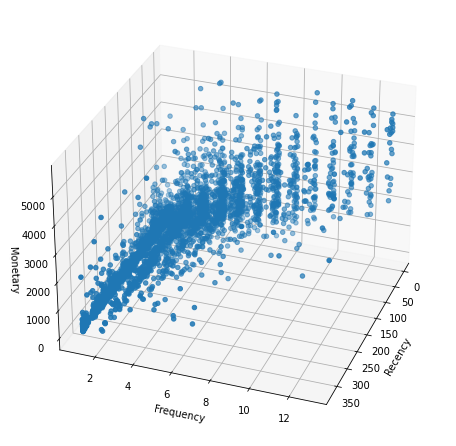

In [44]:
# Создадим трёхмерный объект.
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
# Добавим дополнительную ось в объект картинки.
fig.add_axes(ax)
ax.azim = 20
ax.elev = 30

# Визуализируем данные, передав значения x, y, z, а также информацию о группировке данных по цветам.
ax.scatter(
    rfm_table_cleaned['Recency'].to_list(), 
    rfm_table_cleaned['Frequency'].to_list(),
    rfm_table_cleaned['Monetary'].to_list()
)
# Добавим оси.
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary');


Что здесь можно увидеть? На самом деле, ничего конкретного. Да, видно, что есть клиенты с большими значениями параметров Monetary и Frequency — вероятно, это лучшие клиенты, которые покупают чаще всего и приносят больше всего денег. Однако по общей массе точек сложно сказать, сколько кластеров у нас есть — скорее даже кажется, что пространство не поддаётся кластеризации.

Попробуем методы снижения размерности.



Начнём с метода главных компонент (PCA). Нам известно, что для его стабильной работы данные необходимо стандартизировать/нормализовать. 

Для удобства обернём эти шаги по предобработке данных в pipeline.

Создадим pipeline, в котором будут следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* метод главных компонент с двумя компонентами.

Обучим ваш pipeline на RFM-таблице, очищенной от выбросов, и применим к ней трансформацию.



In [45]:
pipeline_preprocessing = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dimension', decomposition.PCA(n_components=2) )
    ]
)
rfm_table_processed = pipeline_preprocessing.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)

Визуализируем пространство главных компонент после декомпозиции:

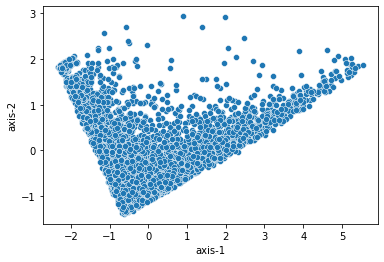

In [46]:
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Попробуем разделить это пространство главных компонент на сегменты. 


Попробуем метод k-means. 

Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно. 

В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.



In [47]:
n_clusters_list = list(range(2, 11))
silhouette_scores = []
# В цикле переберем значения из списка.
for n_clusters in n_clusters_list:
    kmeans = cluster.KMeans(init='k-means++', n_clusters=n_clusters, random_state = 42)
    kmeans.fit(rfm_table_processed)
    clusters = kmeans.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, clusters)
    silhouette_scores.append(silhouette_avg)

silhouette_df = pd.DataFrame({'n_clusters' : n_clusters_list, 'silhouette_score' : silhouette_scores})

px.line(
    silhouette_df,
    x='n_clusters',
    y='silhouette_score'
)
    

Судя по полученным результатам, необходимо взять 3 кластера.


Теперь возьмём EM-алгоритм.

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture) с помощью коэффициента силуэта, перебирая возможные значения от 2 до 10 включительно.
В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.





In [48]:
n_clusters_list = list(range(2, 10))
silhouette_scores = []
# В цикле переберем значения из списка.
for n_clusters in n_clusters_list:
    em = mixture.GaussianMixture(n_components=n_clusters, random_state = 42)
    em.fit(rfm_table_processed)
    clusters = em.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, clusters)
    silhouette_scores.append(silhouette_avg)

silhouette_df = pd.DataFrame({'n_clusters' : n_clusters_list, 'silhouette_score' : silhouette_scores})

px.line(
    silhouette_df,
    x='n_clusters',
    y='silhouette_score'
)

Судя по полученным результатам, необходимо взять 3 кластера.




Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 




In [49]:
model = cluster.KMeans(init='k-means++', n_clusters=3, random_state = 42)
model.fit(rfm_table_processed)

labels = pd.Series(model.labels_.astype('str'), index=rfm_table_processed.index)
display(labels.value_counts())

2    2269
0     999
1     776
dtype: int64

Визуализируем результаты кластеризации:

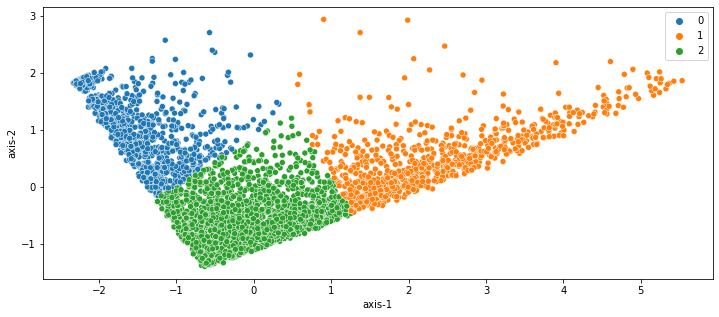

In [50]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(
    data=rfm_table_processed, 
    x='axis-1', 
    y='axis-2', 
    hue=labels
);

Итак, у нас есть три сегмента клиентов. Попробуем составить профиль для этих сегментов.


Для составления профиля кластеров необходимо вернуться от декомпозированных данных к RFM-таблице, очищенной от выбросов.  Сгруппируум RFM-таблицу по полученным кластерам и рассчитайте среднее по каждому из признаков.


In [51]:
cluster_grouped = rfm_table_cleaned.groupby(labels).mean()
display(cluster_grouped.style.background_gradient(cmap='coolwarm'))

,Recency,Frequency,Monetary
0,253.474474,1.403403,386.277297
1,31.943299,7.068299,2657.746997
2,51.221684,2.329220,660.068947


### Полярная диаграмма
Сейчас мы воспользуемся одним из способов визуализации профиля кластеров — Radar Chart (полярная, или лепестковая, диаграмма). Это графическое представление значений нескольких эквивалентных категорий в форме «паутины».
Radar Chart очень часто используется в контексте определения профиля кластеров. На концах «паутины» откладываются оси, которые соответствуют признакам, описывающим объекты. На каждой из осей для каждого кластера откладываются средние значения соответствующих характеристик. Соединив точки по осям, мы получаем многоугольник. 
Пример полярной диаграммы для задачи кластеризации учеников по интересам:

<img src=https://www.datanovia.com/en/wp-content/uploads/2020/12/radar-chart-in-r-customized-fmstb-radar-chart-1.png width=500>

На данной диаграмме видим визуализацию признаков для одного из кластеров. Видно, что ученики, принадлежащие к данному кластеру, в большей степени увлекаются музыкой (Music), а в меньшей степени — программированием (Programm).

В модуле graph_objects библиотеки plotly есть встроенная функция Scatterpolar, которая позволяет построить полярную диаграмму. На основе этой функции мы реализуем собственную функцию plot_cluster_profile(), которая позволит визуализировать профиль каждого из кластеров в виде полярной диаграммы. У этой функции два параметра: grouped_data — сгруппированные по кластерам характеристики объектов (клиентов), n_clusters — количество кластеров. 

Главное условие использования полярной диаграммы — все признаки должны быть приведены к единому масштабу с помощью нормализации, где 1 будет означать максимум, а 0 — минимум. Шаг с нормализацией также добавимв реализацию функции plot_cluster_profile().

In [52]:
def plot_cluster_profile(grouped_data, n_clusters):
    # Нормализуем сгруппированные данные, приводя их к масштабу 0-1.
    scaler = preprocessing.MinMaxScaler()
    grouped_data = pd.DataFrame(scaler.fit_transform(grouped_data), columns=grouped_data.columns)
    # Создаем список признаков.
    features = grouped_data.columns
    # Создаем пустую фигуру.
    fig = go.Figure()
    # В цикле визуализируем полярную диаграмму для каждого кластера.
    for i in range(n_clusters):
        # Создаем полярную диаграмму и добавляем ее на общий график.
        fig.add_trace(go.Scatterpolar(
            r=grouped_data.iloc[i].values, # радиусы
            theta=features, # название засечек
            fill='toself', # заливка многоугольника цветом
            name=f'Cluster {i}', # название - номер кластера
        ))
    # Обновляем параметры фигуры.
    fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=800, # ширина (в пикселях)
        height=800, # высота (в пикселях)
    )
    # Отображаем фигуру.
    fig.show()
    

Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера. 

In [53]:
plot_cluster_profile(cluster_grouped, 3)

### 8. RFM-сегментация клиентов: часть 2

С помощью RFM-анализаудалось выделить три сегмента клиентов. Однако в маркетинге принято оперировать большим их количеством: обычно маркетологи стараются создать стратегию хотя бы для пяти-семи клиентских сегментов в градации от «лояльных» до «потерянных» с промежуточными категориями.

Поэтому, получив обратную связь от маркетологов, вновь принимаемся за работу, пытаясь модифицировать полученное решение.

Ранее мы производили кластеризацию в пространстве главных компонент. 

Попробуем использовать нелинейную трансформацию, алгоритм снижения размерности t-SNE. 


Воспользуемся алгоритмом t-SNE и трансформируем RFM-таблицу, очищенную от выбросов, в двухмерное представление. Также заранее позаботимся о масштабировании признаков.

Для удобства обернём шаги по предобработке данных в pipeline.

Создадим pipeline, который будет содержать следующие шаги:
* стандартизация с помощью StandardScaler с параметрами по умолчанию; 
* алгоритм t-SNE с двумя компонентами, параметрами perplexity=50 и random_state=100.

Обучим ваш pipeline на RFM-таблице (очищенной от выбросов), полученной ранее, и применим к ней трансформацию.





In [54]:
pipeline_preprocessing = pipeline.Pipeline(
    steps=[
        ('scaler', preprocessing.StandardScaler()),
        ('dimension', manifold.TSNE(n_components=2, perplexity=50, random_state=100))
    ]
)
rfm_table_processed = pipeline_preprocessing.fit_transform(rfm_table_cleaned)
rfm_table_processed = pd.DataFrame(rfm_table_processed, columns=['axis-1', 'axis-2'], index=rfm_table_cleaned.index)
print(round(pipeline_preprocessing['dimension'].kl_divergence_, 2))

0.54


Визуализируем пространство после декомпозиции с помощью t-SNE:


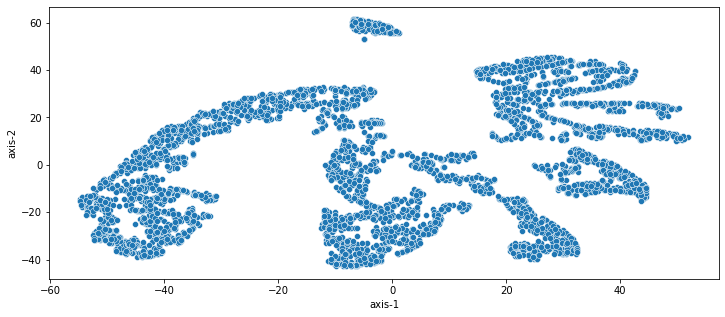

In [55]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2');

Как и ожидалось от t-SNE, алгоритм сгруппировал наиболее похожие объекты в подобие кластеров, причём эти кластеры легко определить.

Теперь воспользуемся алгоритмами кластеризации, чтобы сформировать новые сегменты клиентов.



Попробуем воспользоваться методом k-means. 
Подберем оптимальное количество кластеров для метода k-means с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 
В качестве значения параметра random_state возьмем число 42. Остальные параметры оставим по умолчанию.




In [56]:
n_clusters_list = list(range(3, 9))
silhouette_scores = []
# В цикле переберем значения из списка.
for n_clusters in n_clusters_list:
    kmeans = cluster.KMeans(init='k-means++', n_clusters=n_clusters, random_state = 42)
    kmeans.fit(rfm_table_processed)
    clusters = kmeans.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, clusters)
    silhouette_scores.append(silhouette_avg)

silhouette_df = pd.DataFrame({'n_clusters' : n_clusters_list, 'silhouette_score' : silhouette_scores})

px.line(
    silhouette_df,
    x='n_clusters',
    y='silhouette_score'
)

Судя по полученным результатам, необходимо взять 7 кластеров.


Попробуем воспользоваться EM-алгоритом. 

Подберем оптимальное количество кластеров для EM-алгоритма (GaussianMixture)  с помощью коэффициента силуэта, перебирая возможные значения от 3 до 8 включительно. 

В качестве значения параметра random_state возьмем число 42. Остальные параметры оставьим по умолчанию.




In [57]:
n_clusters_list = list(range(3, 9))
silhouette_scores = []
# В цикле переберем значения из списка.
for n_clusters in n_clusters_list:
    em = mixture.GaussianMixture(n_components=n_clusters, random_state = 42)
    em.fit(rfm_table_processed)
    clusters = em.predict(rfm_table_processed)
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, clusters)
    silhouette_scores.append(silhouette_avg)

silhouette_df = pd.DataFrame({'n_clusters' : n_clusters_list, 'silhouette_score' : silhouette_scores})

px.line(
    silhouette_df,
    x='n_clusters',
    y='silhouette_score'
)

Судя по полученным результатам, необходимо взять 4 кластера.


И попробуем воспользоваться алгоритмом алгомеративной кластеризации (AgglomerativeClustering).

Подберем оптимальное количество кластеров для алгоритма агломеративной кластеризации с помощью коэффициента силуэта, перебирая возможные значения от 2 до 8 включительно. 

Все параметры, за исключением числа кластеров, оставим по умолчанию.




In [58]:
n_clusters_list = list(range(2, 9))
silhouette_scores = []
# В цикле переберем значения из списка.
for n_clusters in n_clusters_list:
    agglomerative = cluster.AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative.fit(rfm_table_processed)
    clusters = agglomerative.labels_
    silhouette_avg = metrics.silhouette_score(rfm_table_processed, clusters)
    silhouette_scores.append(silhouette_avg)

silhouette_df = pd.DataFrame({'n_clusters' : n_clusters_list, 'silhouette_score' : silhouette_scores})

px.line(
    silhouette_df,
    x='n_clusters',
    y='silhouette_score'
)



Обучим лучшую модель с подобранным ранее количеством кластеров на декомпозированных данных. 




In [59]:
model = cluster.KMeans(init='k-means++', n_clusters=7, random_state = 42)
model.fit(rfm_table_processed)

labels = pd.Series(model.labels_.astype('str'), index=rfm_table_processed.index)
display(labels.value_counts())

1    914
4    683
0    656
2    543
5    446
6    405
3    397
dtype: int64

Визуализируем результаты кластеризации:

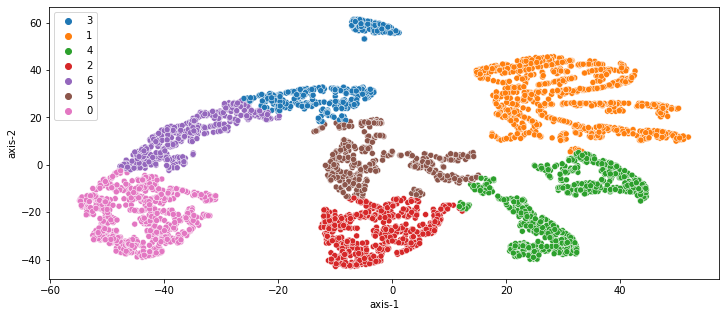

In [60]:
fig = plt.figure(figsize=(12, 5))
sns.scatterplot(data=rfm_table_processed, x='axis-1', y='axis-2', hue=model.labels_.astype('str'));


Итак, у нас есть 7 сегментов клиентов. Cоставиv профиль для этих сегментов. 




Для составления профиля кластеров нам необходимо вернуться от декомпозированных данных к RFM-таблице (очищенной от выбросов).

Сгруппируем RFM-таблицу по полученным кластерам и рассчитаем среднее по каждому из признаков. Для наглядности округлим все значения в столбцах до целого числа.



In [61]:
cluster_grouped = rfm_table_cleaned.groupby(labels).mean().round(0)
display(cluster_grouped.style.background_gradient(cmap='coolwarm'))

,Recency,Frequency,Monetary
0,46.000000,1.000000,322.000000
1,32.000000,7.000000,2417.000000
2,40.000000,2.000000,614.000000
3,313.000000,1.000000,261.000000
4,40.000000,3.000000,995.000000
5,196.000000,2.000000,670.000000
6,181.000000,1.000000,273.000000


Визуализируем профили кластеров в виде полярной диаграммы на основе средних RFM-характеристик, вычисленных для каждого кластера.

In [62]:
plot_cluster_profile(cluster_grouped, 7)

## 9. RFM-кластеризация клиентов: часть 3



Сведём задачу кластеризации к задаче классификации. У нас есть истинные метки кластеров, а есть клиенты, которые описываются RFM-характеристиками. Обучим модель, которая на основе RFM-характеристик будет предсказывать клиентский сегмент. 

In [63]:
# Создадим матрицу наблюдений.
X = rfm_table_cleaned
# Создадим вектор правильных ответов.
y = labels

Разделим исходные данные на тренировочную и тестовую выборки в соотношении 80/20. В качестве параметра random_state возьмем число 42.

In [66]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)


Начнём со случайного леса. С помощью GridSearchCV организуем перебор параметров случайного леса (RandomForestClassifier) на следующей сетке параметров:

```
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}
```
В качестве параметра random_state для модели случайного леса используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5.



In [69]:
param_grid = {
    'max_depth': range(5, 15),
    'criterion': ['gini', 'entropy'],
    'n_estimators': [100, 200, 500]
}

gs = model_selection.GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
gs.fit(X_train, y_train)
gs.best_estimator_

RandomForestClassifier(max_depth=13, n_estimators=200, random_state=42)

In [71]:
rf = gs.best_estimator_
rf.fit(X_train, y_train)
y_pred_test = rf.predict(X_test)
print(round(metrics.accuracy_score(y_pred_test, y_test), 3))

0.985


Значение метрики accuracy очень высокое, но не идеальное. Попробуем его улучшить, воспользовавшись бустингом.


С помощью GridSearchCV организуем перебор параметров градиентного бустинга (GradientBoostingClassifier) на следующей сетке параметров:
```
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}
```

В качестве параметра random_state для модели градиентного бустинга используем число 42.
В качестве метрики используем accuracy. Количество фолдов для кросс-валидации — 5. 




In [73]:
param_grid = {
    'max_depth': range(3, 7),
    'learning_rate': [0.001, 0.01, 0.1],
    'n_estimators': [100, 200, 500]
}

gs = model_selection.GridSearchCV(
    estimator=ensemble.GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    scoring='accuracy'
)
gs.fit(X_train, y_train)
gs.best_estimator_

GradientBoostingClassifier(max_depth=4, n_estimators=200, random_state=42)

In [74]:
gbc = gs.best_estimator_
gbc.fit(X_train, y_train)
y_pred_test = gbc.predict(X_test)
print(round(metrics.accuracy_score(y_pred_test, y_test), 3))

0.983


Отлично, мы справились с проблемой непараметричности t-SNE и смогли перейти от решения задачи кластеризации к задаче классификации. Теперь у нас есть модель, которая на основе RFM-характерик клиента автоматически определяет его сегмент.